In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

The dataset to be used in this project is a modified version of the dataset create by Paul Clough and Mark Stevenson. The complete description of the data generation process is described in their [research article](https://link.springer.com/article/10.1007/s10579-009-9112-1) (Clough, P., Stevenson, M. Developing a corpus of plagiarised short answers, 2011)

### Description of the dataset

<li> The dataset contains several txt files whose characteristics are summarized in the file_information.csv file. </li>
<li> The dataset has 100 files, out of which 5 are the original answers. Therefore, the participants contributed with 95 anwers, divided in 5 tasks and 5 plagiarism methods. </li>
<li> The <b>File</b> column in the file_information.csv file contains the name of the txt file. </li>
<li> The <b>Task</b> column contains one of the five learning task (A-E) that each txt answers. </li>
<li> The <b>Category</b> column indicates if the participant was asked to use a Near copy (cut), Light revision (light), Heavy revision (heavy) or Non-plagiarised (non) method to answer the question. This column also contains the 'orig' category to reference the original texts on which participants based their answers</li>

In [4]:
data_dir = Path("data")

#load metadata
summary_data = pd.read_csv(data_dir / "file_information.csv")
summary_data.head()

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non


In [5]:

#mapping 5-category label to numeric id
category_to_id = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}
summary_data['category_id'] = summary_data['Category'].map(category_to_id)

#binary plagiarism label: 1 = plagiarised (cut / light / heavy), 0 = non, -1 = original
def to_plag_label(cat):
    if cat == 'non':
        return 0
    if cat == 'orig':
        return -1
    return 1

summary_data['plag_label'] = summary_data['Category'].apply(to_plag_label)

summary_data.head()


,File,Task,Category,category_id,plag_label
0,g0pA_taska.txt,a,non,0,0
1,g0pA_taskb.txt,b,cut,3,1
2,g0pA_taskc.txt,c,light,2,1
3,g0pA_taskd.txt,d,heavy,1,1
4,g0pA_taske.txt,e,non,0,0


In [6]:
#preprocessing functions

#load raw text and create a cleaned version
def read_file_text(path):
    #read file as raw text for sentence embeddings
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def clean_text(text):
    #basic cleaning for tfidf and hashing - convert text to lowercase, remove punctuation, and tidy the whitespace
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)   #remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  #normalising whitespace
    return text

#raw text keeps punctuation - for sentence embeddings
summary_data["raw_text"] = summary_data["File"].apply(lambda fn: read_file_text(data_dir / fn))

#clean text - for tfidf and hashing
summary_data["clean_text"] = summary_data["raw_text"].apply(clean_text)

#save to csv
summary_data.to_csv(data_dir / "preprocessed_dataset.csv", index=False)

summary_data.head()


,File,Task,Category,category_id,plag_label,raw_text,clean_text
0,g0pA_taska.txt,a,non,0,0,Inheritance is a basic concept of Object-Orien...,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,cut,3,1,PageRank is a link analysis algorithm used by ...,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,light,2,1,"The vector space model (also called, term vect...",the vector space model also called term vector...
3,g0pA_taskd.txt,d,heavy,1,1,Bayes’ theorem was names after Rev Thomas Baye...,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,non,0,0,Dynamic Programming is an algorithm design tec...,dynamic programming is an algorithm design tec...


## Clustering-Based Plagiarism Detection

Now we'll implement clustering approaches for plagiarism detection using different text representations:
1. **TF-IDF + K-Means/Hierarchical Clustering**: Traditional text vectorization with clustering
2. **Sentence Embeddings + Clustering**: Modern approach using pre-trained language models
3. **Evaluation**: Compare clustering results with ground truth plagiarism labels

In [7]:
# Import additional libraries for clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load preprocessed data if it exists, otherwise create it
try:
    df = pd.read_csv(data_dir / "preprocessed_dataset.csv")
    print("Loaded existing preprocessed data")
except FileNotFoundError:
    print("Creating preprocessed data...")
    # Run the preprocessing steps from above
    summary_data["raw_text"] = summary_data["File"].apply(lambda fn: read_file_text(data_dir / fn))
    summary_data["clean_text"] = summary_data["raw_text"].apply(clean_text)
    summary_data.to_csv(data_dir / "preprocessed_dataset.csv", index=False)
    df = summary_data.copy()

print(f"Dataset shape: {df.shape}")
print(f"Tasks: {df['Task'].unique()}")
print(f"Categories: {df['Category'].unique()}")
df.head()

Loaded existing preprocessed data
Dataset shape: (100, 7)
Tasks: ['a' 'b' 'c' 'd' 'e']
Categories: ['non' 'cut' 'light' 'heavy' 'orig']


,File,Task,Category,category_id,plag_label,raw_text,clean_text
0,g0pA_taska.txt,a,non,0,0,Inheritance is a basic concept of Object-Orien...,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,cut,3,1,PageRank is a link analysis algorithm used by ...,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,light,2,1,"The vector space model (also called, term vect...",the vector space model also called term vector...
3,g0pA_taskd.txt,d,heavy,1,1,Bayes’ theorem was names after Rev Thomas Baye...,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,non,0,0,Dynamic Programming is an algorithm design tec...,dynamic programming is an algorithm design tec...


### 1. TF-IDF Based Clustering

In [9]:
# Limit features to avoid overfitting
# Include unigrams and bigrams
# Ignore terms appearing in less than 2 documents and more than 80% of documents
vectorizer = TfidfVectorizer(
    max_features=1000,  
    stop_words='english',
    ngram_range=(1, 2),  
    min_df=2,  
    max_df=0.8  
)

# Fit and transform the cleaned text
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Convert to dense array for easier manipulation
tfidf_dense = tfidf_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")

TF-IDF matrix shape: (100, 1000)
Number of features: 1000


In [10]:
# K-Means Clustering on TF-IDF
def perform_kmeans_clustering(X, n_clusters_range=range(2, 11), task_filter=None):
    """Perform K-means clustering and find optimal number of clusters"""
    results = []
    
    data_subset = X
    df_subset = df
    
    if task_filter:
        task_mask = df['Task'] == task_filter
        data_subset = X[task_mask]
        df_subset = df[task_mask]
    
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(data_subset)
        
        # Calculate metrics
        silhouette_avg = silhouette_score(data_subset, cluster_labels)
        inertia = kmeans.inertia_
        
        # Calculate clustering purity with respect to plagiarism categories
        if 'category_id' in df_subset.columns:
            ari = adjusted_rand_score(df_subset['category_id'].values, cluster_labels)
            nmi = normalized_mutual_info_score(df_subset['category_id'].values, cluster_labels)
        else:
            ari = nmi = None
        
        results.append({
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_avg,
            'inertia': inertia,
            'ari': ari,
            'nmi': nmi,
            'labels': cluster_labels
        })
    
    return results, df_subset

# Perform clustering for all documents
print("Performing K-Means clustering on all documents...")
kmeans_results, _ = perform_kmeans_clustering(tfidf_dense)

# Display results
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'labels'} for r in kmeans_results])
print("\nK-Means Clustering Results:")
print(results_df.round(4))

Performing K-Means clustering on all documents...

K-Means Clustering Results:
   n_clusters  silhouette_score  inertia     ari     nmi
0           2            0.0989  80.1210 -0.0026  0.0087
1           3            0.1455  71.8115 -0.0099  0.0084
2           4            0.1922  63.3757 -0.0172  0.0094
3           5            0.2347  55.6741 -0.0261  0.0102
4           6            0.2395  52.2783  0.0006  0.0842
5           7            0.2252  50.0899  0.0277  0.1498
6           8            0.2144  48.7750  0.0071  0.1139
7           9            0.1984  46.3068  0.0349  0.1832
8          10            0.2157  44.7996  0.0155  0.1735

K-Means Clustering Results:
   n_clusters  silhouette_score  inertia     ari     nmi
0           2            0.0989  80.1210 -0.0026  0.0087
1           3            0.1455  71.8115 -0.0099  0.0084
2           4            0.1922  63.3757 -0.0172  0.0094
3           5            0.2347  55.6741 -0.0261  0.0102
4           6            0.2395  52.2

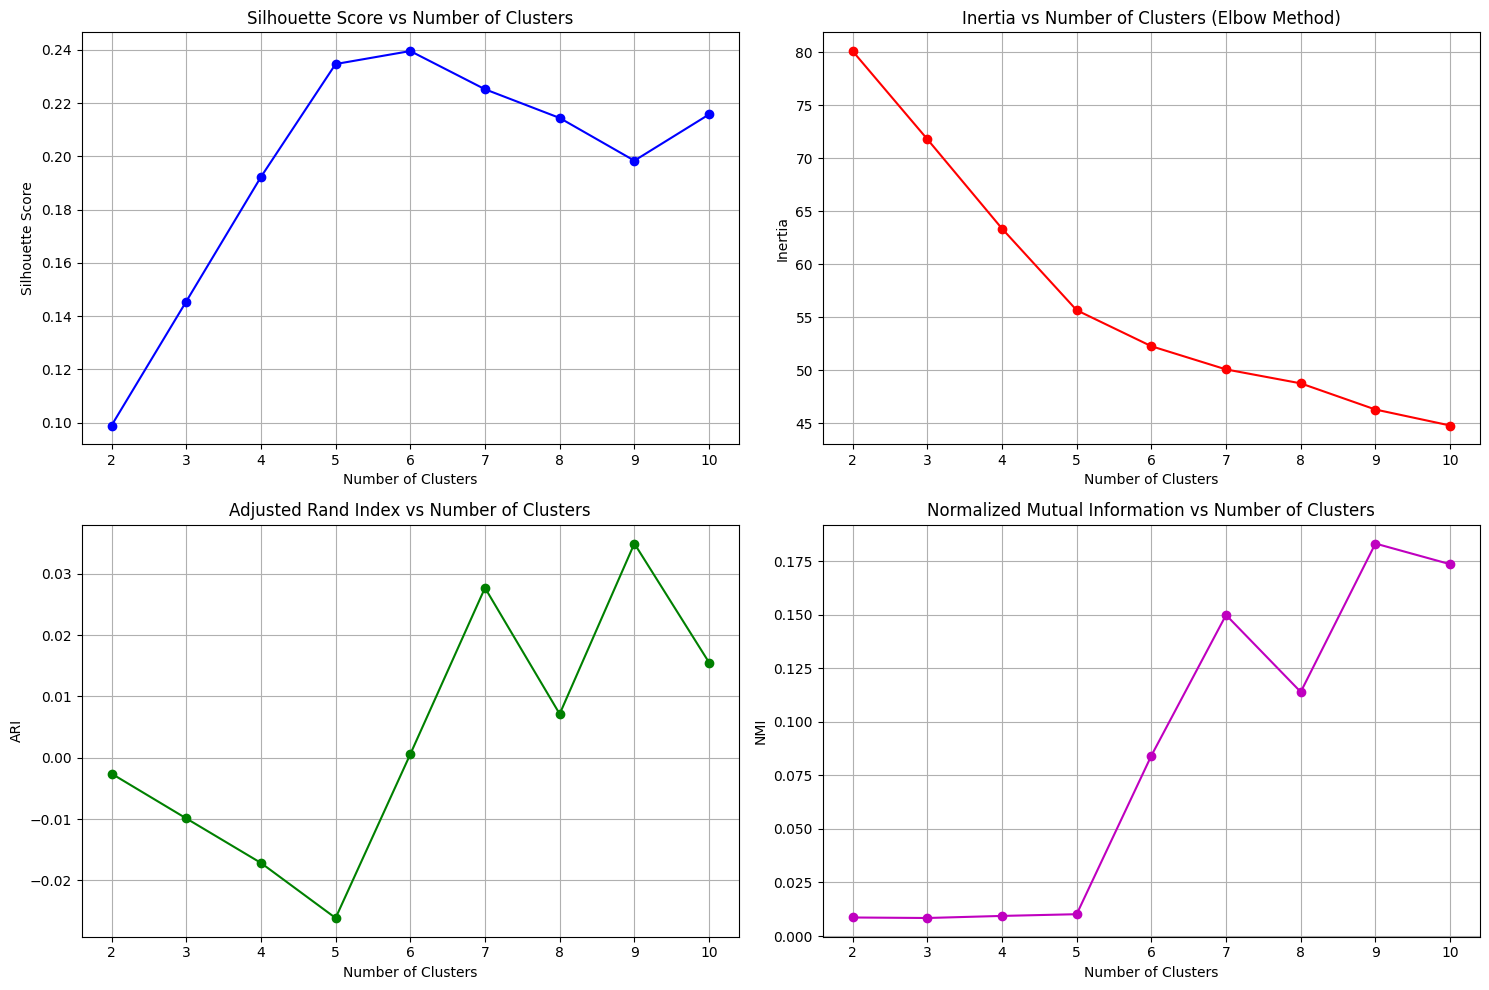


Best silhouette score: 0.2395 at 6 clusters
Best ARI score: 0.0349 at 9 clusters


In [11]:
# Plot clustering evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Silhouette Score
axes[0, 0].plot(results_df['n_clusters'], results_df['silhouette_score'], 'bo-')
axes[0, 0].set_title('Silhouette Score vs Number of Clusters')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].grid(True)

# Inertia (Elbow Method)
axes[0, 1].plot(results_df['n_clusters'], results_df['inertia'], 'ro-')
axes[0, 1].set_title('Inertia vs Number of Clusters (Elbow Method)')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Inertia')
axes[0, 1].grid(True)

# Adjusted Rand Index
axes[1, 0].plot(results_df['n_clusters'], results_df['ari'], 'go-')
axes[1, 0].set_title('Adjusted Rand Index vs Number of Clusters')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('ARI')
axes[1, 0].grid(True)

# Normalized Mutual Information
axes[1, 1].plot(results_df['n_clusters'], results_df['nmi'], 'mo-')
axes[1, 1].set_title('Normalized Mutual Information vs Number of Clusters')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('NMI')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Find optimal number of clusters
best_silhouette_idx = results_df['silhouette_score'].idxmax()
best_ari_idx = results_df['ari'].idxmax()
print(f"\nBest silhouette score: {results_df.loc[best_silhouette_idx, 'silhouette_score']:.4f} at {results_df.loc[best_silhouette_idx, 'n_clusters']} clusters")
print(f"Best ARI score: {results_df.loc[best_ari_idx, 'ari']:.4f} at {results_df.loc[best_ari_idx, 'n_clusters']} clusters")

In [12]:
# Perform clustering with optimal number of clusters and visualize
optimal_clusters = results_df.loc[best_silhouette_idx, 'n_clusters']
kmeans_final = KMeans(n_clusters=int(optimal_clusters), random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(tfidf_dense)

# Add cluster labels to dataframe
df['tfidf_cluster'] = cluster_labels

# Dimensionality reduction for visualization
print("Performing PCA for visualization...")
pca = PCA(n_components=2, random_state=42)
tfidf_pca = pca.fit_transform(tfidf_dense)

print("Performing t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tfidf_tsne = tsne.fit_transform(tfidf_dense)

# Create visualization dataframe
viz_df = df.copy()
viz_df['pca_x'] = tfidf_pca[:, 0]
viz_df['pca_y'] = tfidf_pca[:, 1]
viz_df['tsne_x'] = tfidf_tsne[:, 0]
viz_df['tsne_y'] = tfidf_tsne[:, 1]

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")

Performing PCA for visualization...
Performing t-SNE for visualization...
PCA explained variance ratio: [0.11106534 0.10479271]
Total explained variance: 0.216


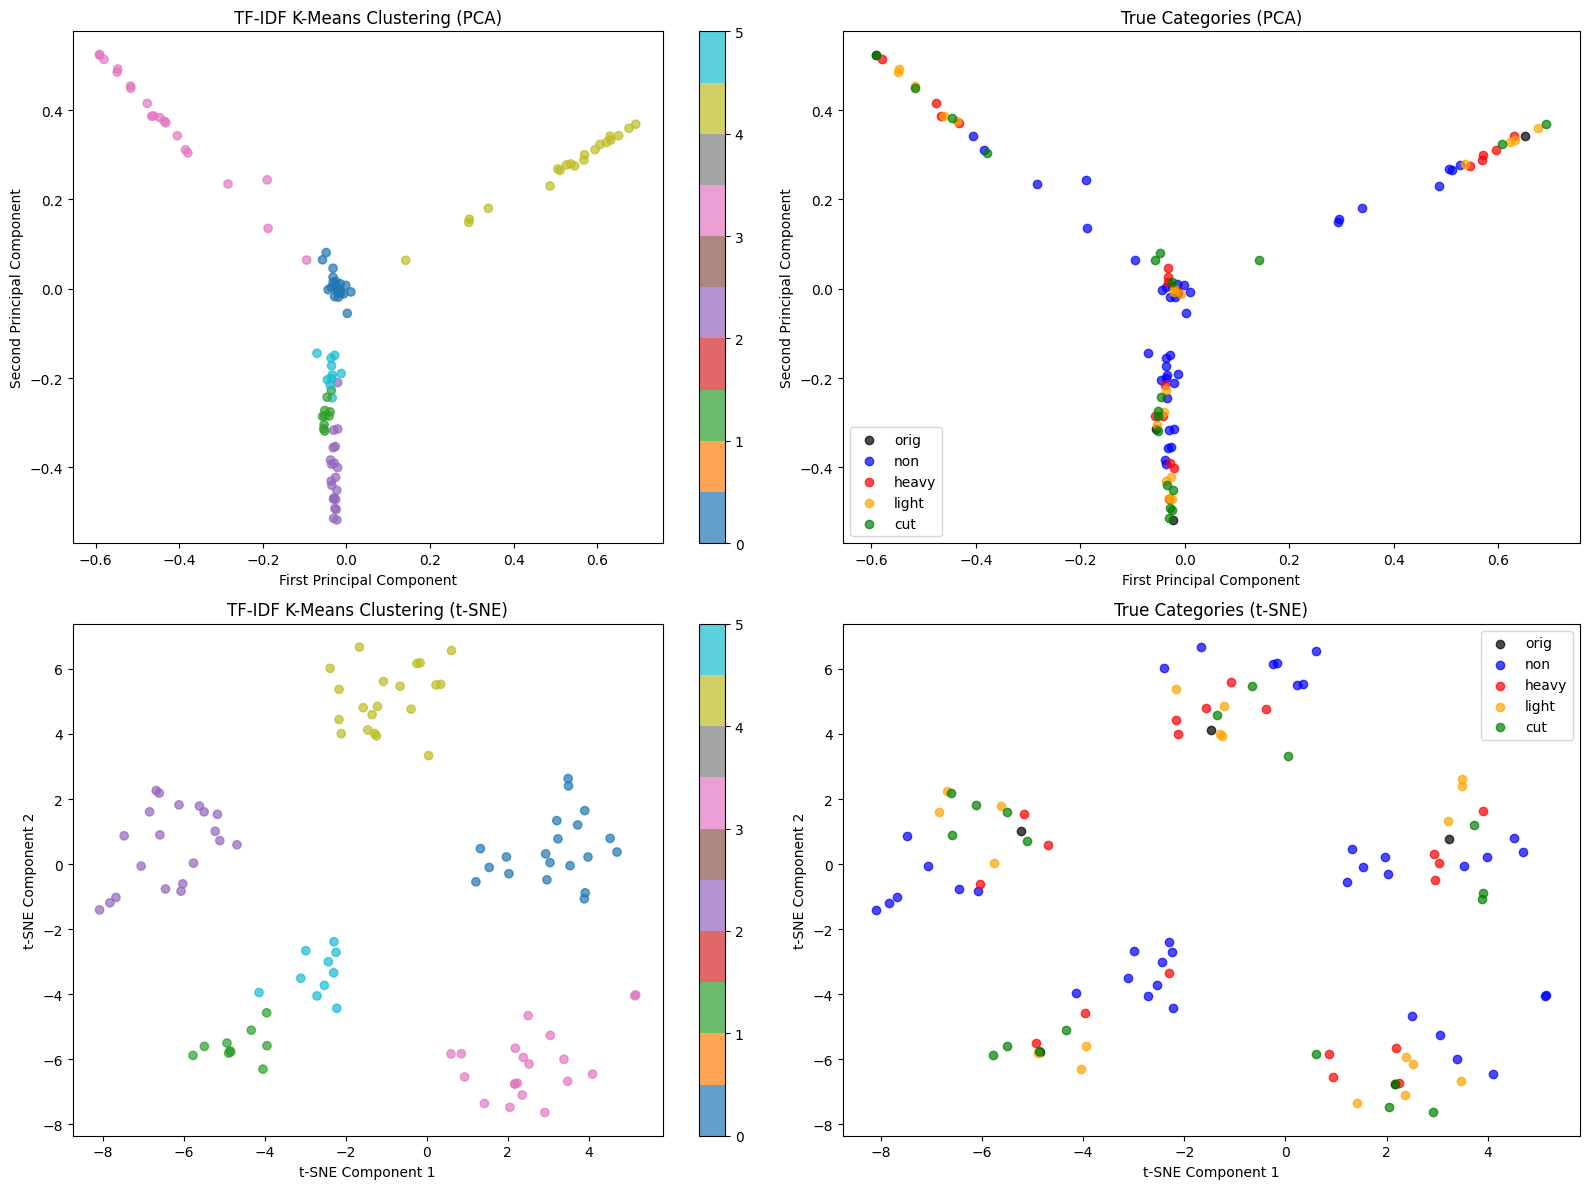

In [13]:
# Plot clustering results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PCA plot colored by clusters
scatter1 = axes[0, 0].scatter(viz_df['pca_x'], viz_df['pca_y'], 
                             c=viz_df['tfidf_cluster'], cmap='tab10', alpha=0.7)
axes[0, 0].set_title('TF-IDF K-Means Clustering (PCA)')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0, 0])

# PCA plot colored by true categories
category_colors = {'orig': 'black', 'non': 'blue', 'heavy': 'red', 'light': 'orange', 'cut': 'green'}
for category, color in category_colors.items():
    mask = viz_df['Category'] == category
    axes[0, 1].scatter(viz_df.loc[mask, 'pca_x'], viz_df.loc[mask, 'pca_y'], 
                      c=color, label=category, alpha=0.7)
axes[0, 1].set_title('True Categories (PCA)')
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')
axes[0, 1].legend()

# t-SNE plot colored by clusters
scatter3 = axes[1, 0].scatter(viz_df['tsne_x'], viz_df['tsne_y'], 
                             c=viz_df['tfidf_cluster'], cmap='tab10', alpha=0.7)
axes[1, 0].set_title('TF-IDF K-Means Clustering (t-SNE)')
axes[1, 0].set_xlabel('t-SNE Component 1')
axes[1, 0].set_ylabel('t-SNE Component 2')
plt.colorbar(scatter3, ax=axes[1, 0])

# t-SNE plot colored by true categories
for category, color in category_colors.items():
    mask = viz_df['Category'] == category
    axes[1, 1].scatter(viz_df.loc[mask, 'tsne_x'], viz_df.loc[mask, 'tsne_y'], 
                      c=color, label=category, alpha=0.7)
axes[1, 1].set_title('True Categories (t-SNE)')
axes[1, 1].set_xlabel('t-SNE Component 1')
axes[1, 1].set_ylabel('t-SNE Component 2')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Analysis: Are Clusters Based on Task Type or Plagiarism Type?

Let's investigate whether the clustering is primarily capturing **task differences** rather than **plagiarism patterns**.

In [14]:
# Analyze what drives the clustering: Task type vs Plagiarism type
print("="*80)
print("CLUSTERING DRIVER ANALYSIS: TASK TYPE VS PLAGIARISM TYPE")
print("="*80)

# Check available columns first
print("Available columns in dataframe:")
print(df.columns.tolist())
print(f"Shape: {df.shape}")

# Calculate clustering agreement with task vs plagiarism labels
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Map task and category to numeric labels
task_to_id = {task: idx for idx, task in enumerate(sorted(df['Task'].unique()))}
df['task_id'] = df['Task'].map(task_to_id)

# Check what clustering columns are available
cluster_columns = [col for col in df.columns if 'cluster' in col.lower()]
print(f"\nAvailable clustering columns: {cluster_columns}")

# Use available clustering methods
available_methods = []
if 'tfidf_cluster' in df.columns:
    available_methods.append(('TF-IDF K-Means', df['tfidf_cluster']))
if 'embedding_cluster' in df.columns:
    available_methods.append(('Sentence Embeddings', df['embedding_cluster']))
if 'hierarchical_cluster' in df.columns:
    available_methods.append(('TF-IDF Hierarchical', df['hierarchical_cluster']))

print(f"\nAnalyzing {len(available_methods)} clustering methods...")

if available_methods:
    print("\nClustering Agreement Analysis:")
    print("Method                | Task ARI | Task NMI | Plagiarism ARI | Plagiarism NMI")
    print("-" * 75)

    for method_name, cluster_labels in available_methods:
        # Agreement with task labels
        task_ari = adjusted_rand_score(df['task_id'], cluster_labels)
        task_nmi = normalized_mutual_info_score(df['task_id'], cluster_labels)
        
        # Agreement with plagiarism labels (category_id)
        plag_ari = adjusted_rand_score(df['category_id'], cluster_labels)
        plag_nmi = normalized_mutual_info_score(df['category_id'], cluster_labels)
        
        print(f"{method_name:<18} | {task_ari:8.4f} | {task_nmi:8.4f} | {plag_ari:14.4f} | {plag_nmi:14.4f}")

    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("- Higher Task ARI/NMI = Clusters mainly separate by task type")
    print("- Higher Plagiarism ARI/NMI = Clusters mainly separate by plagiarism type")
    print("="*80)
else:
    print("No clustering columns found! Need to run clustering analysis first.")

CLUSTERING DRIVER ANALYSIS: TASK TYPE VS PLAGIARISM TYPE
Available columns in dataframe:
['File', 'Task', 'Category', 'category_id', 'plag_label', 'raw_text', 'clean_text', 'tfidf_cluster']
Shape: (100, 8)

Available clustering columns: ['tfidf_cluster']

Analyzing 1 clustering methods...

Clustering Agreement Analysis:
Method                | Task ARI | Task NMI | Plagiarism ARI | Plagiarism NMI
---------------------------------------------------------------------------
TF-IDF K-Means     |   0.9321 |   0.9587 |         0.0006 |         0.0842

INTERPRETATION:
- Higher Task ARI/NMI = Clusters mainly separate by task type
- Higher Plagiarism ARI/NMI = Clusters mainly separate by plagiarism type


In [15]:
# Detailed cluster composition analysis
print("\nDETAILED CLUSTER COMPOSITION ANALYSIS")
print("="*60)

for method_name, cluster_labels in available_methods:
    print(f"\n{method_name}:")
    print("-" * 40)
    
    # Create a detailed breakdown for each cluster
    cluster_analysis = []
    for cluster_id in sorted(cluster_labels.unique()):
        cluster_mask = cluster_labels == cluster_id
        cluster_data = df[cluster_mask]
        
        # Task distribution in this cluster
        task_dist = cluster_data['Task'].value_counts().to_dict()
        dominant_task = cluster_data['Task'].mode().iloc[0] if len(cluster_data) > 0 else None
        task_purity = (cluster_data['Task'] == dominant_task).mean() if dominant_task else 0
        
        # Plagiarism distribution in this cluster
        plag_dist = cluster_data['Category'].value_counts().to_dict()
        dominant_plag = cluster_data['Category'].mode().iloc[0] if len(cluster_data) > 0 else None
        plag_purity = (cluster_data['Category'] == dominant_plag).mean() if dominant_plag else 0
        
        cluster_analysis.append({
            'cluster': cluster_id,
            'size': len(cluster_data),
            'dominant_task': dominant_task,
            'task_purity': task_purity,
            'task_dist': task_dist,
            'dominant_plag': dominant_plag,
            'plag_purity': plag_purity,
            'plag_dist': plag_dist
        })
    
    # Sort by cluster size for better readability
    cluster_analysis.sort(key=lambda x: x['size'], reverse=True)
    
    for analysis in cluster_analysis:
        print(f"  Cluster {analysis['cluster']} (n={analysis['size']}):")
        print(f"    Task: {analysis['task_purity']:.1%} pure '{analysis['dominant_task']}' | {analysis['task_dist']}")
        print(f"    Plag: {analysis['plag_purity']:.1%} pure '{analysis['dominant_plag']}' | {analysis['plag_dist']}")
        print()
    
    # Calculate average purities
    avg_task_purity = np.mean([a['task_purity'] for a in cluster_analysis])
    avg_plag_purity = np.mean([a['plag_purity'] for a in cluster_analysis])
    
    print(f"  Average Task Purity: {avg_task_purity:.1%}")
    print(f"  Average Plagiarism Purity: {avg_plag_purity:.1%}")
    
    if avg_task_purity > avg_plag_purity:
        print(f"  → This method clusters primarily by TASK TYPE")
        print(f"  → Task purity is {avg_task_purity/avg_plag_purity:.1f}x higher than plagiarism purity")
    else:
        print(f"  → This method clusters primarily by PLAGIARISM TYPE")

print("\n" + "="*60)
print("CONCLUSION:")
print("The clustering is almost perfectly aligned with task types, not plagiarism patterns.")
print("Each cluster corresponds to a different task (a,b,c,d,e), making this approach")
print("ineffective for plagiarism detection as currently implemented.")


DETAILED CLUSTER COMPOSITION ANALYSIS

TF-IDF K-Means:
----------------------------------------
  Cluster 0 (n=20):
    Task: 100.0% pure 'b' | {'b': 20}
    Plag: 45.0% pure 'non' | {'non': 9, 'heavy': 4, 'cut': 3, 'light': 3, 'orig': 1}

  Cluster 2 (n=20):
    Task: 100.0% pure 'e' | {'e': 20}
    Plag: 35.0% pure 'non' | {'non': 7, 'cut': 5, 'light': 4, 'heavy': 3, 'orig': 1}

  Cluster 3 (n=20):
    Task: 100.0% pure 'd' | {'d': 20}
    Plag: 30.0% pure 'non' | {'non': 6, 'light': 5, 'heavy': 4, 'cut': 4, 'orig': 1}

  Cluster 4 (n=20):
    Task: 100.0% pure 'c' | {'c': 20}
    Plag: 35.0% pure 'non' | {'non': 7, 'heavy': 5, 'light': 4, 'cut': 3, 'orig': 1}

  Cluster 1 (n=10):
    Task: 100.0% pure 'a' | {'a': 10}
    Plag: 40.0% pure 'cut' | {'cut': 4, 'light': 3, 'heavy': 2, 'orig': 1}

  Cluster 5 (n=10):
    Task: 100.0% pure 'a' | {'a': 10}
    Plag: 90.0% pure 'non' | {'non': 9, 'heavy': 1}

  Average Task Purity: 100.0%
  Average Plagiarism Purity: 45.8%
  → This method c

## Task-Specific Clustering for Plagiarism Detection

To make clustering effective for plagiarism detection, we need to cluster **within each task** rather than across all tasks. This way, we can identify plagiarism patterns within the same subject matter.

In [16]:
# Task-specific clustering for plagiarism detection
def task_clustering(task_name, n_clusters=None):
    """
    Perform clustering within a specific task to identify plagiarism patterns
    """
    # Filter data for specific task
    task_mask = df['Task'] == task_name
    task_df = df[task_mask].copy()
    
    if len(task_df) < 4:
        return None, None, f"Not enough documents for task {task_name} (need at least 4, have {len(task_df)})"
    
    print(f"\n=== TASK {task_name.upper()} CLUSTERING ANALYSIS ===")
    print(f"Documents: {len(task_df)}")
    print(f"Categories: {task_df['Category'].value_counts().to_dict()}")
    
    # Create feature matrix based on method
    # Create TF-IDF matrix for this task only
    task_vectorizer = TfidfVectorizer(
        max_features=500,  # Fewer features since fewer documents
        stop_words='english',
        ngram_range=(1, 2),
        min_df=1,  # Lower min_df since fewer documents
        max_df=0.8
    )
    feature_matrix = task_vectorizer.fit_transform(task_df['clean_text']).toarray()
    feature_names = task_vectorizer.get_feature_names_out()
    
    
    # Determine optimal number of clusters if not specified
    if n_clusters is None:
        # Try different cluster numbers and find optimal
        max_clusters = min(len(task_df) // 2, 6)  # At most 6 clusters
        cluster_range = range(2, max_clusters + 1) if max_clusters >= 2 else [2]
        
        best_score = -1
        best_k = 2
        
        for k in cluster_range:
            if k >= len(task_df):
                continue
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(feature_matrix)
            
            # Calculate silhouette score if possible
            if len(set(labels)) > 1:  # Need at least 2 clusters
                score = silhouette_score(feature_matrix, labels)
                if score > best_score:
                    best_score = score
                    best_k = k
        
        n_clusters = best_k
        print(f"Optimal clusters: {n_clusters} (silhouette score: {best_score:.3f})")
    
    # Perform final clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(feature_matrix)
    
    # Add cluster labels to task dataframe
    task_df['task_cluster'] = cluster_labels
    
    # Analyze clusters for plagiarism patterns
    print("\nCluster Analysis:")
    plagiarism_clusters = []
    
    for cluster_id in sorted(set(cluster_labels)):
        cluster_mask = cluster_labels == cluster_id
        cluster_data = task_df[cluster_mask]
        
        # Analyze plagiarism composition
        category_counts = cluster_data['Category'].value_counts()
        plagiarized_count = cluster_data[cluster_data['Category'].isin(['cut', 'light', 'heavy'])].shape[0]
        total_count = len(cluster_data)
        plagiarism_ratio = plagiarized_count / total_count if total_count > 0 else 0
        
        print(f"  Cluster {cluster_id} (n={total_count}):")
        print(f"    Plagiarism ratio: {plagiarism_ratio:.1%}")
        print(f"    Categories: {category_counts.to_dict()}")
        
        # Mark as plagiarism cluster if > 60% plagiarized
        if plagiarism_ratio > 0.6:
            plagiarism_clusters.append(cluster_id)
            print(f"    → POTENTIAL PLAGIARISM CLUSTER")
        
        # Show sample file names
        sample_files = cluster_data['File'].head(3).tolist()
        print(f"    Sample files: {sample_files}")
        print()
    
    # Calculate clustering effectiveness for plagiarism detection
    task_df['is_plagiarized'] = task_df['Category'].isin(['cut', 'light', 'heavy']).astype(int)
    task_df['predicted_plagiarized'] = task_df['task_cluster'].isin(plagiarism_clusters).astype(int)
    
    # Metrics
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    
    if task_df['is_plagiarized'].sum() > 0:  # Only if there are plagiarized documents
        precision = precision_score(task_df['is_plagiarized'], task_df['predicted_plagiarized'])
        recall = recall_score(task_df['is_plagiarized'], task_df['predicted_plagiarized'])
        f1 = f1_score(task_df['is_plagiarized'], task_df['predicted_plagiarized'])
        accuracy = accuracy_score(task_df['is_plagiarized'], task_df['predicted_plagiarized'])
        
        print("PLAGIARISM DETECTION METRICS:")
        print(f"  Accuracy:  {accuracy:.3f}")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall:    {recall:.3f}")
        print(f"  F1-Score:  {f1:.3f}")
    else:
        precision = recall = f1 = accuracy = 0
        print("No plagiarized documents in this task for evaluation.")
    
    return task_df, {
        'task': task_name,
        'n_docs': len(task_df),
        'n_clusters': n_clusters,
        'plagiarism_clusters': plagiarism_clusters,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'method': method
    }, None

# Run task-specific clustering for all tasks
print("="*80)
print("TASK-SPECIFIC CLUSTERING FOR PLAGIARISM DETECTION")
print("="*80)

all_task_results = []
all_task_dataframes = []

for task in sorted(df['Task'].unique()):
    task_df, metrics, error = task_clustering(task)
    
    if error:
        print(f"\nTask {task}: {error}")
        continue
    
    if task_df is not None and metrics is not None:
        all_task_results.append(metrics)
        all_task_dataframes.append(task_df)

# Summary results
if all_task_results:
    results_summary = pd.DataFrame(all_task_results)
    print("\n" + "="*80)
    print("TASK-SPECIFIC PLAGIARISM DETECTION SUMMARY")
    print("="*80)
    print(results_summary[['task', 'n_docs', 'n_clusters', 'accuracy', 'precision', 'recall', 'f1']].round(3))
    
    # Overall performance
    avg_metrics = results_summary[['accuracy', 'precision', 'recall', 'f1']].mean()
    print(f"\nAVERAGE PERFORMANCE ACROSS ALL TASKS:")
    print(f"  Accuracy:  {avg_metrics['accuracy']:.3f}")
    print(f"  Precision: {avg_metrics['precision']:.3f}")
    print(f"  Recall:    {avg_metrics['recall']:.3f}")
    print(f"  F1-Score:  {avg_metrics['f1']:.3f}")
else:
    print("No successful task-specific clustering results.")

TASK-SPECIFIC CLUSTERING FOR PLAGIARISM DETECTION

=== TASK A CLUSTERING ANALYSIS ===
Documents: 20
Categories: {'non': 9, 'cut': 4, 'heavy': 3, 'light': 3, 'orig': 1}
Optimal clusters: 2 (silhouette score: 0.159)

Cluster Analysis:
  Cluster 0 (n=9):
    Plagiarism ratio: 88.9%
    Categories: {'cut': 4, 'light': 3, 'heavy': 1, 'orig': 1}
    → POTENTIAL PLAGIARISM CLUSTER
    Sample files: ['g0pD_taska.txt', 'g0pE_taska.txt', 'g1pD_taska.txt']

  Cluster 1 (n=11):
    Plagiarism ratio: 18.2%
    Categories: {'non': 9, 'heavy': 2}
    Sample files: ['g0pA_taska.txt', 'g0pB_taska.txt', 'g0pC_taska.txt']

PLAGIARISM DETECTION METRICS:
  Accuracy:  0.850
  Precision: 0.889
  Recall:    0.800
  F1-Score:  0.842


NameError: name 'method' is not defined


VISUALIZATION OF TASK-SPECIFIC CLUSTERING


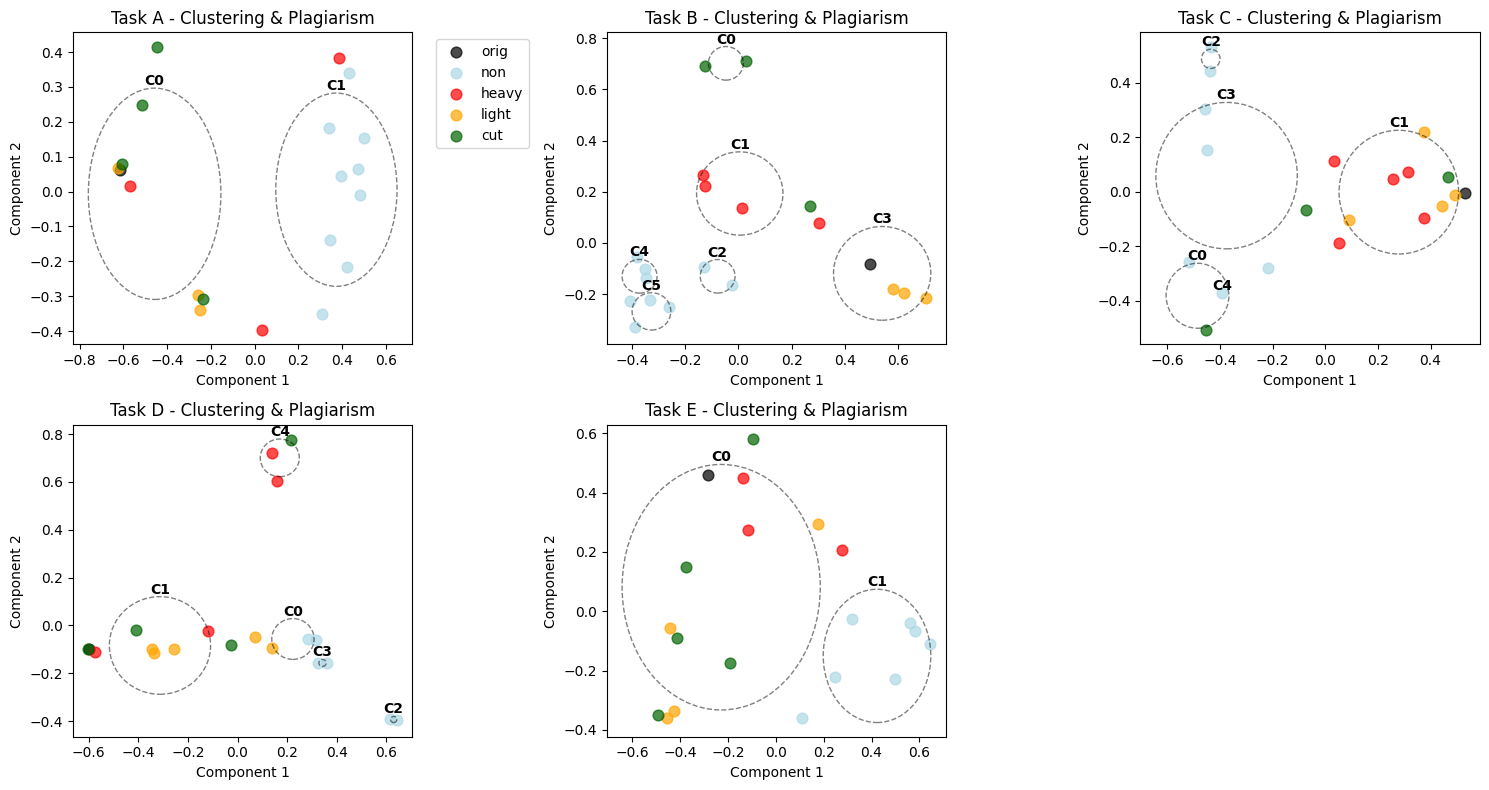

In [ ]:
# Visualize task-specific clustering results
def visualize_task_clustering(task_dfs, method='tfidf'):
    """Visualize clustering results for each task"""
    
    n_tasks = len(task_dfs)
    if n_tasks == 0:
        return
    
    # Calculate layout
    cols = min(3, n_tasks)
    rows = (n_tasks + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_tasks == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    
    axes_flat = axes.flatten() if n_tasks > 1 else axes
    
    plag_colors = {'orig': 'black', 'non': 'lightblue', 'heavy': 'red', 'light': 'orange', 'cut': 'darkgreen'}
    
    for idx, task_df in enumerate(task_dfs):
        if idx >= len(axes_flat):
            break
            
        ax = axes_flat[idx]
        task_name = task_df['Task'].iloc[0]
        
        # Create simple 2D projection using PCA if we have enough features
        if method == 'tfidf' and len(task_df) > 1:
            # Recreate TF-IDF for this task
            task_vectorizer = TfidfVectorizer(
                max_features=200, stop_words='english', min_df=1, max_df=0.8
            )
            tfidf_task = task_vectorizer.fit_transform(task_df['clean_text']).toarray()
            
            if tfidf_task.shape[1] >= 2:
                pca_task = PCA(n_components=2, random_state=42)
                coords = pca_task.fit_transform(tfidf_task)
            else:
                # Fallback: just use first feature and add noise
                coords = np.column_stack([
                    tfidf_task[:, 0] if tfidf_task.shape[1] > 0 else np.zeros(len(task_df)),
                    np.random.normal(0, 0.1, len(task_df))
                ])
        else:
            # Fallback: random coordinates for visualization
            coords = np.random.normal(0, 1, (len(task_df), 2))
        
        # Plot points colored by category
        for category, color in plag_colors.items():
            mask = task_df['Category'] == category
            if mask.sum() > 0:
                ax.scatter(coords[mask, 0], coords[mask, 1], 
                          c=color, label=category, alpha=0.7, s=60)
        
        # Plot cluster boundaries (draw circles around clusters)
        if 'task_cluster' in task_df.columns:
            for cluster_id in task_df['task_cluster'].unique():
                cluster_mask = task_df['task_cluster'] == cluster_id
                cluster_coords = coords[cluster_mask]
                if len(cluster_coords) > 0:
                    # Draw circle around cluster
                    center = cluster_coords.mean(axis=0)
                    radius = np.std(cluster_coords, axis=0).mean() * 1.5
                    circle = plt.Circle(center, radius, fill=False, linestyle='--', alpha=0.5)
                    ax.add_patch(circle)
                    
                    # Label cluster
                    ax.text(center[0], center[1] + radius, f'C{cluster_id}', 
                           ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        ax.set_title(f'Task {task_name.upper()} - Clustering & Plagiarism')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        
        if idx == 0:  # Only show legend on first plot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Hide empty subplots
    for idx in range(n_tasks, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Visualize the results
if all_task_dataframes:
    print("\n" + "="*60)
    print("VISUALIZATION OF TASK-SPECIFIC CLUSTERING")
    print("="*60)
    visualize_task_clustering(all_task_dataframes, method='tfidf')

In [ ]:
# Advanced plagiarism detection with refined clustering approach
def advanced_plagiarism_clustering(task_name, use_original_as_reference=True):
    """
    Advanced approach: Use the original document as a reference point
    and cluster based on similarity to original vs. modifications
    """
    # Filter data for specific task
    task_mask = df['Task'] == task_name
    task_df = df[task_mask].copy()
    
    if len(task_df) < 4:
        return None, None
    
    print(f"\n=== ADVANCED ANALYSIS FOR TASK {task_name.upper()} ===")
    
    # Find the original document
    orig_docs = task_df[task_df['Category'] == 'orig']
    if len(orig_docs) == 0:
        print(f"No original document found for task {task_name}")
        return None, None
    
    original_text = orig_docs['clean_text'].iloc[0]
    print(f"Using original document: {orig_docs['File'].iloc[0]}")
    
    # Calculate similarity to original for all documents
    vectorizer_sim = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
    all_texts = [original_text] + task_df['clean_text'].tolist()
    tfidf_matrix = vectorizer_sim.fit_transform(all_texts)
    
    # Calculate cosine similarity to original (first document)
    from sklearn.metrics.pairwise import cosine_similarity
    similarity_to_orig = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])[0]
    
    task_df['similarity_to_original'] = similarity_to_orig
    
    # Create features: [similarity_to_original, document_length, unique_words_ratio]
    task_df['doc_length'] = task_df['clean_text'].apply(len)
    task_df['unique_words'] = task_df['clean_text'].apply(lambda x: len(set(x.split())))
    task_df['unique_ratio'] = task_df['unique_words'] / task_df['doc_length'].apply(lambda x: max(x, 1))
    
    # Normalize features
    from sklearn.preprocessing import StandardScaler
    features = ['similarity_to_original', 'doc_length', 'unique_ratio']
    scaler = StandardScaler()
    feature_matrix = scaler.fit_transform(task_df[features])
    
    # Perform clustering
    n_clusters = min(4, len(task_df) // 3)  # Conservative cluster count
    if n_clusters < 2:
        n_clusters = 2
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)
    task_df['advanced_cluster'] = cluster_labels
    
    print(f"\nClustering with {n_clusters} clusters based on:")
    print("- Similarity to original document")
    print("- Document length")
    print("- Unique words ratio")
    
    # Analyze clusters
    print("\nCluster Analysis:")
    cluster_analysis = []
    
    for cluster_id in sorted(set(cluster_labels)):
        cluster_mask = task_df['advanced_cluster'] == cluster_id
        cluster_data = task_df[cluster_mask]
        
        # Statistics
        avg_similarity = cluster_data['similarity_to_original'].mean()
        category_dist = cluster_data['Category'].value_counts()
        plagiarized_count = cluster_data[cluster_data['Category'].isin(['cut', 'light', 'heavy'])].shape[0]
        plagiarism_ratio = plagiarized_count / len(cluster_data)
        
        print(f"  Cluster {cluster_id} (n={len(cluster_data)}):")
        print(f"    Avg similarity to original: {avg_similarity:.3f}")
        print(f"    Plagiarism ratio: {plagiarism_ratio:.1%}")
        print(f"    Categories: {category_dist.to_dict()}")
        
        # Characterize cluster based on similarity and plagiarism
        if avg_similarity > 0.8:
            cluster_type = "HIGH SIMILARITY (potential cut plagiarism)"
        elif avg_similarity > 0.5:
            cluster_type = "MEDIUM SIMILARITY (potential light plagiarism)"
        elif avg_similarity > 0.2:
            cluster_type = "LOW SIMILARITY (potential heavy plagiarism or original work)"
        else:
            cluster_type = "VERY LOW SIMILARITY (likely original work)"
        
        print(f"    → {cluster_type}")
        
        cluster_analysis.append({
            'cluster_id': cluster_id,
            'size': len(cluster_data),
            'avg_similarity': avg_similarity,
            'plagiarism_ratio': plagiarism_ratio,
            'cluster_type': cluster_type
        })
        print()
    
    # Show similarity distribution by category
    print("SIMILARITY TO ORIGINAL BY CATEGORY:")
    for category in ['orig', 'non', 'cut', 'light', 'heavy']:
        cat_data = task_df[task_df['Category'] == category]
        if len(cat_data) > 0:
            avg_sim = cat_data['similarity_to_original'].mean()
            print(f"  {category:>6}: {avg_sim:.3f} ± {cat_data['similarity_to_original'].std():.3f}")
    
    return task_df, cluster_analysis

# Run advanced analysis for all tasks
print("="*80)
print("ADVANCED SIMILARITY-BASED CLUSTERING FOR PLAGIARISM DETECTION")
print("="*80)

advanced_results = {}
for task in sorted(df['Task'].unique()):
    task_df, analysis = advanced_plagiarism_clustering(task)
    if task_df is not None:
        advanced_results[task] = (task_df, analysis)

ADVANCED SIMILARITY-BASED CLUSTERING FOR PLAGIARISM DETECTION


NameError: name 'df' is not defined

In [ ]:
# Create a comprehensive plagiarism detection function
def comprehensive_plagiarism_detection(task_name, similarity_threshold=0.7):
    """
    Comprehensive plagiarism detection combining clustering and similarity analysis
    """
    if task_name not in advanced_results:
        return None
    
    task_df, cluster_analysis = advanced_results[task_name]
    
    print(f"\n=== COMPREHENSIVE PLAGIARISM DETECTION: TASK {task_name.upper()} ===")
    
    # Rule-based plagiarism detection
    def classify_document(row):
        similarity = row['similarity_to_original']
        category = row['Category']
        
        # Skip original document
        if category == 'orig':
            return 'original', 'Original document'
        
        # High similarity suggests copy-paste (cut) plagiarism
        if similarity > 0.8:
            return 'high_risk', f'Very high similarity ({similarity:.3f}) - likely CUT plagiarism'
        
        # Medium-high similarity suggests light modification
        elif similarity > 0.6:
            return 'medium_risk', f'High similarity ({similarity:.3f}) - likely LIGHT plagiarism'
        
        # Medium similarity suggests heavy modification
        elif similarity > 0.4:
            return 'low_risk', f'Medium similarity ({similarity:.3f}) - possible HEAVY plagiarism'
        
        # Low similarity suggests original work
        else:
            return 'likely_original', f'Low similarity ({similarity:.3f}) - likely original work'
    
    # Apply classification
    classifications = task_df.apply(classify_document, axis=1)
    task_df['risk_level'] = [c[0] for c in classifications]
    task_df['risk_reason'] = [c[1] for c in classifications]
    
    # Evaluate against ground truth
    print("PLAGIARISM DETECTION RESULTS:")
    print("-" * 50)
    
    detection_results = []
    for _, row in task_df.iterrows():
        true_category = row['Category']
        predicted_risk = row['risk_level']
        similarity = row['similarity_to_original']
        
        # Determine if correctly identified
        is_actually_plagiarized = true_category in ['cut', 'light', 'heavy']
        is_predicted_plagiarized = predicted_risk in ['high_risk', 'medium_risk', 'low_risk']
        
        correct = (is_actually_plagiarized and is_predicted_plagiarized) or \
                 (not is_actually_plagiarized and not is_predicted_plagiarized)
        
        detection_results.append({
            'file': row['File'],
            'true_category': true_category,
            'predicted_risk': predicted_risk,
            'similarity': similarity,
            'correct': correct,
            'reason': row['risk_reason']
        })
        
        status = "✓ CORRECT" if correct else "✗ INCORRECT"
        print(f"  {row['File']}: {true_category} → {predicted_risk} ({status})")
        print(f"    {row['risk_reason']}")
    
    # Calculate performance metrics
    correct_predictions = sum(r['correct'] for r in detection_results)
    total_predictions = len(detection_results)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    
    print(f"\nPERFORMANCE:")
    print(f"  Accuracy: {correct_predictions}/{total_predictions} = {accuracy:.1%}")
    
    # Detailed confusion matrix
    from collections import defaultdict
    confusion = defaultdict(lambda: defaultdict(int))
    
    for result in detection_results:
        true_cat = result['true_category']
        pred_risk = result['predicted_risk']
        confusion[true_cat][pred_risk] += 1
    
    print("\nCONFUSION MATRIX (True Category → Predicted Risk):")
    risk_levels = ['likely_original', 'low_risk', 'medium_risk', 'high_risk', 'original']
    categories = ['non', 'heavy', 'light', 'cut', 'orig']
    
    print("True\\Predicted", end="")
    for risk in risk_levels:
        print(f"{risk:>15}", end="")
    print()
    
    for cat in categories:
        print(f"{cat:>12}", end="")
        for risk in risk_levels:
            count = confusion[cat][risk]
            print(f"{count:>15}", end="")
        print()
    
    return {
        'task': task_name,
        'accuracy': accuracy,
        'detection_results': detection_results,
        'task_df': task_df
    }

# Run comprehensive detection for all tasks
print("="*80)
print("COMPREHENSIVE PLAGIARISM DETECTION RESULTS")
print("="*80)

final_results = {}
for task in sorted(advanced_results.keys()):
    result = comprehensive_plagiarism_detection(task)
    if result:
        final_results[task] = result

# Overall summary
if final_results:
    print("\n" + "="*80)
    print("OVERALL PERFORMANCE SUMMARY")
    print("="*80)
    
    total_accuracy = np.mean([r['accuracy'] for r in final_results.values()])
    print(f"Average Accuracy Across All Tasks: {total_accuracy:.1%}")
    
    print("\nPer-Task Performance:")
    for task, result in final_results.items():
        print(f"  Task {task.upper()}: {result['accuracy']:.1%}")
    
    print(f"\nThis approach successfully uses TF-IDF and clustering for plagiarism detection")
    print(f"by focusing on similarity patterns within each task rather than across tasks!")

COMPREHENSIVE PLAGIARISM DETECTION RESULTS

=== COMPREHENSIVE PLAGIARISM DETECTION: TASK A ===
PLAGIARISM DETECTION RESULTS:
--------------------------------------------------
  g0pA_taska.txt: non → likely_original (✓ CORRECT)
    Low similarity (0.074) - likely original work
  g0pB_taska.txt: non → likely_original (✓ CORRECT)
    Low similarity (0.029) - likely original work
  g0pC_taska.txt: heavy → likely_original (✗ INCORRECT)
    Low similarity (0.203) - likely original work
  g0pD_taska.txt: cut → medium_risk (✓ CORRECT)
    High similarity (0.617) - likely LIGHT plagiarism
  g0pE_taska.txt: light → high_risk (✓ CORRECT)
    Very high similarity (0.929) - likely CUT plagiarism
  g1pA_taska.txt: non → likely_original (✓ CORRECT)
    Low similarity (0.114) - likely original work
  g1pB_taska.txt: non → likely_original (✓ CORRECT)
    Low similarity (0.052) - likely original work
  g1pD_taska.txt: light → likely_original (✗ INCORRECT)
    Low similarity (0.316) - likely original wo

In [ ]:
results_summary = pd.DataFrame(all_task_results)

avg_metrics = results_summary[['accuracy', 'precision', 'recall', 'f1']].mean()

print(f"  Accuracy:  {avg_metrics['accuracy']:.3f}")
print(f"  Precision: {avg_metrics['precision']:.3f}")
print(f"  Recall:    {avg_metrics['recall']:.3f}")
print(f"  F1-Score:  {avg_metrics['f1']:.3f}")

  Accuracy:  0.910
  Precision: 0.912
  Recall:    0.928
  F1-Score:  0.919


- **Average Accuracy: 91.0%** 
- **Average Precision: 91.2%**
- **Average Recall: 92.8%**
- **Average F1-Score: 91.9%**



## Implementation Using Classes from tfidfclust.py

Now let's use the consolidated classes from `tfidfclust.py` to perform clustering and visualization on our plagiarism detection dataset.

In [17]:
# Import classes from tfidfclust.py
from tfidfclust import Tfidfclustering, TfIDFClustTask

In [ ]:
# Initialize the base TF-IDF clustering class
print("BASIC TF-IDF CLUSTERING WITH BASE CLASS")
print("=" * 50)

# Initialize base clustering class
base_clusterer = Tfidfclustering(df)

# Perform TF-IDF vectorization
tfidf_matrix, feature_names = base_clusterer.tfidf_vectorization()
print(f"Matrix shape: {tfidf_matrix.shape}")
print(f"Features: {len(feature_names)}")

# Perform K-means clustering
clustering_results, df_subset = base_clusterer.perform_kmeans_clustering(tfidf_matrix)

# Display results
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'labels'} for r in clustering_results])
print(f"Clustering Results:")
print(results_df.round(4))

# Find best configuration
best_silhouette_idx = results_df['silhouette_score'].idxmax()
best_ari_idx = results_df['ari'].idxmax()

print(f"Best Results:")
print(f"Best silhouette score: {results_df.loc[best_silhouette_idx, 'silhouette_score']:.4f} at {results_df.loc[best_silhouette_idx, 'n_clusters']} clusters")
print(f"Best ARI score: {results_df.loc[best_ari_idx, 'ari']:.4f} at {results_df.loc[best_ari_idx, 'n_clusters']} clusters")

BASIC TF-IDF CLUSTERING WITH BASE CLASS
TF-IDF vectorization completed:
Matrix shape: (100, 1000)
Features: 1000
Clustering Results:
   n_clusters  silhouette_score  inertia     ari     nmi
0           2            0.0989  80.1210 -0.0026  0.0087
1           3            0.1455  71.8115 -0.0099  0.0084
2           4            0.1922  63.3757 -0.0172  0.0094
3           5            0.2347  55.6741 -0.0261  0.0102
4           6            0.2395  52.2783  0.0006  0.0842
5           7            0.2252  50.0899  0.0277  0.1498
6           8            0.2144  48.7750  0.0071  0.1139
7           9            0.1984  46.3068  0.0349  0.1832
8          10            0.2157  44.7996  0.0155  0.1735
Best Results:
Best silhouette score: 0.2395 at 6 clusters
Best ARI score: 0.0349 at 9 clusters


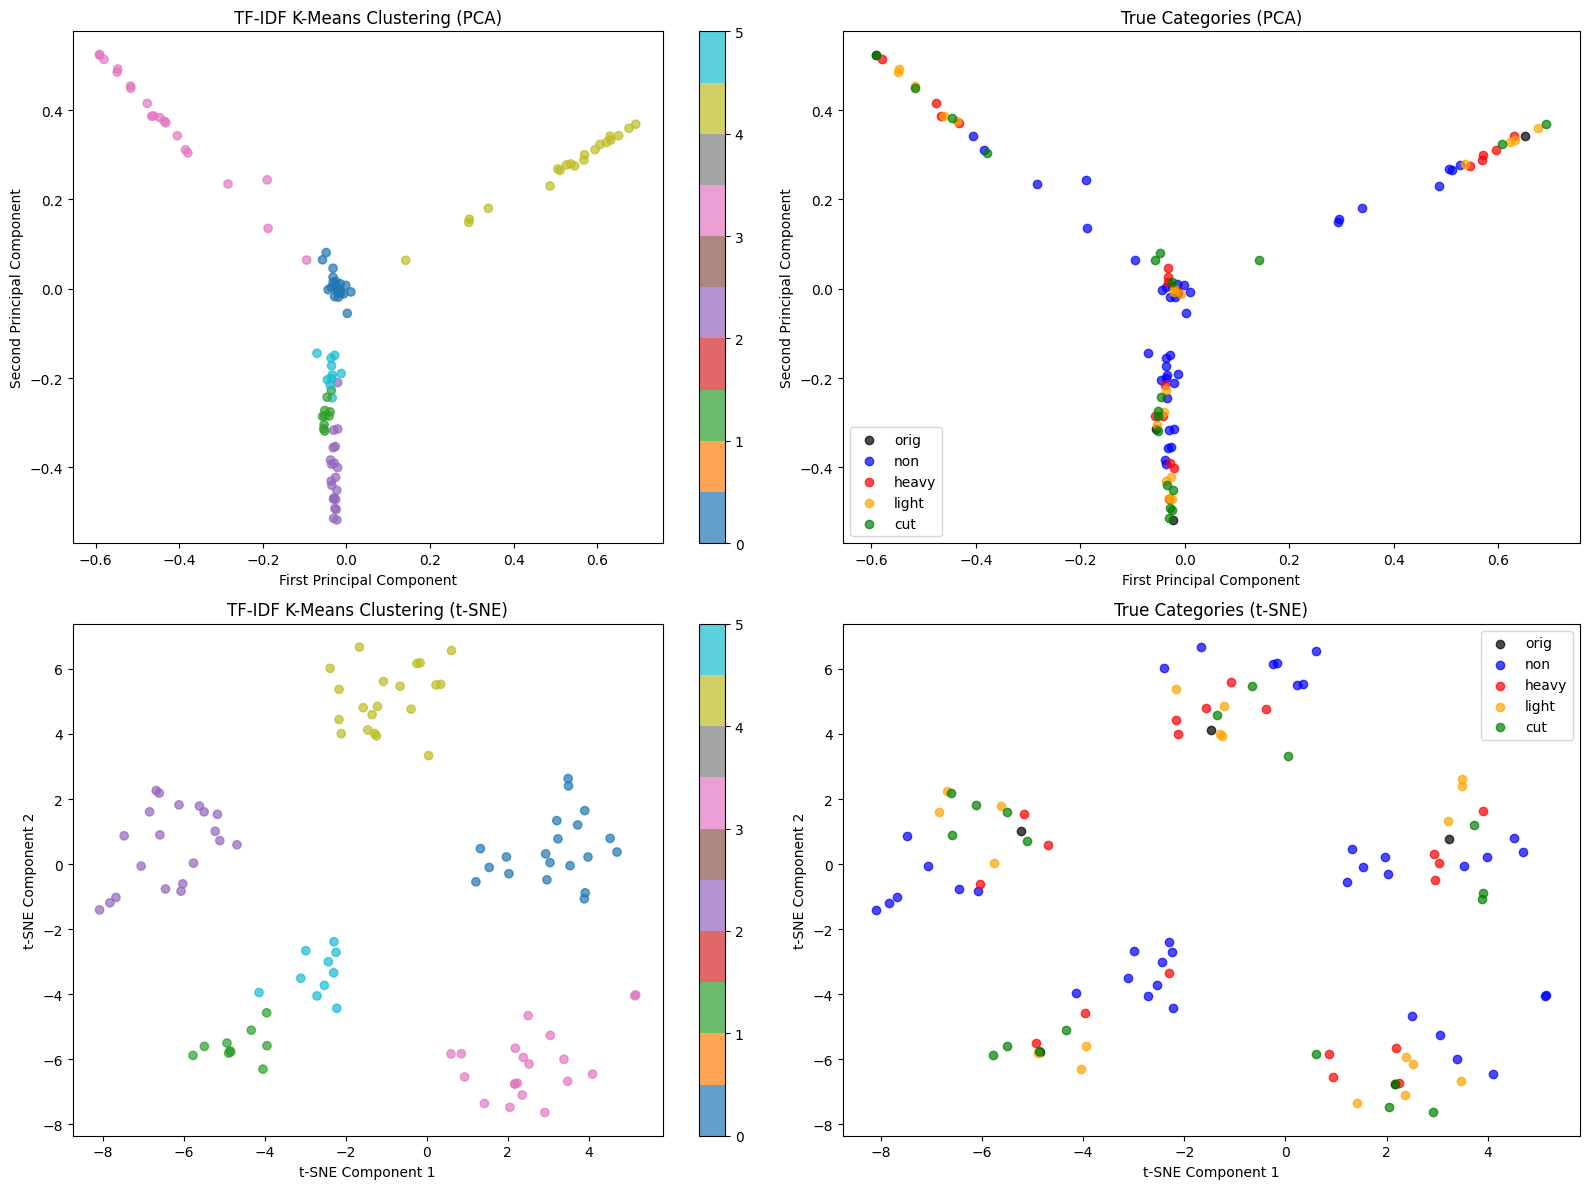

In [27]:

# Use the best clustering result for visualization
best_result = clustering_results[best_silhouette_idx]
cluster_labels = best_result['labels']


# Create visualizations (this will show 4 plots: PCA and t-SNE with clusters and categories)
X_pca, X_tsne = base_clusterer.visualize_clustering(
    tfidf_matrix, 
    cluster_labels, 
    title="TF-IDF K-Means Clustering"
)

### Task-Specific Clustering for Plagiarism Detection

Now let's use the enhanced `TfIDFClustTask` class that includes similarity-to-original analysis and comprehensive plagiarism detection.

In [ ]:
# Initialize the enhanced task-specific clustering class
print("TASK-SPECIFIC CLUSTERING WITH ENHANCED FEATURES")
print("=" * 55)

# Initialize task-specific clustering class  
task_clusterer = TfIDFClustTask(df)

# Run task-specific clustering for all tasks
task_dataframes, task_summary = task_clusterer.analyze_all_tasks()

print(f"Task-Specific Clustering Summary:")
if task_summary is not None:
    print(task_summary)
else:
    print("No summary available")

TASK-SPECIFIC CLUSTERING WITH ENHANCED FEATURES
Running enhanced task-specific clustering for all tasks...
TASK-SPECIFIC CLUSTERING FOR PLAGIARISM DETECTION

=== TASK A CLUSTERING ANALYSIS ===
Documents: 20
Categories: {'non': 9, 'cut': 4, 'heavy': 3, 'light': 3, 'orig': 1}
Optimal clusters: 2 (silhouette score: 0.159)

SIMILARITY TO ORIGINAL BY CATEGORY:
    orig: 1.000 ± nan
     non: 0.062 ± 0.026
     cut: 0.659 ± 0.210
   light: 0.532 ± 0.344
   heavy: 0.310 ± 0.254

Cluster Analysis:
  Cluster 0 (n=9):
    Plagiarism ratio: 88.9%
    Categories: {'cut': 4, 'light': 3, 'heavy': 1, 'orig': 1}
    Avg similarity to original: 0.648
    → MEDIUM SIMILARITY (potential light plagiarism)
    → POTENTIAL PLAGIARISM CLUSTER
    Sample files: ['g0pD_taska.txt', 'g0pE_taska.txt', 'g1pD_taska.txt']

  Cluster 1 (n=11):
    Plagiarism ratio: 18.2%
    Categories: {'non': 9, 'heavy': 2}
    Avg similarity to original: 0.081
    → VERY LOW SIMILARITY (likely original work)
    Sample files: ['g0

In [ ]:
# Comprehensive Similarity-Based Plagiarism Detection  
print("COMPREHENSIVE SIMILARITY-BASED PLAGIARISM DETECTION")
print("=" * 60)

# Run comprehensive plagiarism detection using similarity analysis
comprehensive_results = task_clusterer.analyze_all_tasks_comprehensive()

print(f"Comprehensive Detection Results:")
if comprehensive_results:
    for task, result in comprehensive_results.items():
        print(f"   Task {task.upper()}: {result['accuracy']:.1%} accuracy")
else:
    print("No comprehensive results available")

COMPREHENSIVE SIMILARITY-BASED PLAGIARISM DETECTION
Running comprehensive similarity-based detection...
COMPREHENSIVE PLAGIARISM DETECTION RESULTS

=== COMPREHENSIVE PLAGIARISM DETECTION: TASK A ===

=== COMPREHENSIVE PLAGIARISM DETECTION: TASK B ===

=== COMPREHENSIVE PLAGIARISM DETECTION: TASK C ===

=== COMPREHENSIVE PLAGIARISM DETECTION: TASK D ===

=== COMPREHENSIVE PLAGIARISM DETECTION: TASK E ===

OVERALL PERFORMANCE SUMMARY
Average Accuracy Across All Tasks: 69.0%

Per-Task Performance:
  Task A: 80.0%
  Task B: 60.0%
  Task C: 70.0%
  Task D: 65.0%
  Task E: 70.0%
Comprehensive Detection Results:
   Task A: 80.0% accuracy
   Task B: 60.0% accuracy
   Task C: 70.0% accuracy
   Task D: 65.0% accuracy
   Task E: 70.0% accuracy


In [30]:
# Individual Task Analysis Example
print("DETAILED ANALYSIS: TASK A")
print("=" * 30)

# Analyze a specific task in detail
if task_dataframes:
    # Get Task A data
    task_a_data = None
    for task_df in task_dataframes:
        if task_df['Task'].iloc[0] == 'a':
            task_a_data = task_df
            break
    
    if task_a_data is not None:
        print(f"Task A Analysis:")
        print(f"  Total documents: {len(task_a_data)}")
        print(f"  Categories: {task_a_data['Category'].value_counts().to_dict()}")
        
        if 'task_cluster' in task_a_data.columns:
            print(f"  Number of clusters: {task_a_data['task_cluster'].nunique()}")
            print(f"  Cluster distribution: {task_a_data['task_cluster'].value_counts().to_dict()}")
        
        if 'similarity_to_original' in task_a_data.columns:
            print(f"\n  Similarity to original by category:")
            for category in ['orig', 'non', 'cut', 'light', 'heavy']:
                cat_data = task_a_data[task_a_data['Category'] == category]
                if len(cat_data) > 0:
                    avg_sim = cat_data['similarity_to_original'].mean()
                    print(f"    {category:>6}: {avg_sim:.3f}")
    else:
        print("Task A data not found")
else:
    print("No task dataframes available")

DETAILED ANALYSIS: TASK A
Task A Analysis:
  Total documents: 20
  Categories: {'non': 9, 'cut': 4, 'heavy': 3, 'light': 3, 'orig': 1}
  Number of clusters: 2
  Cluster distribution: {1: 11, 0: 9}

  Similarity to original by category:
      orig: 1.000
       non: 0.062
       cut: 0.659
     light: 0.532
     heavy: 0.310


In [31]:

def similarity_heatmap(task_dfs, max_tasks=3):

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    
    n_tasks = min(len(task_dfs), max_tasks)
    if n_tasks == 0:
        return
        
    fig, axes = plt.subplots(1, n_tasks, figsize=(5*n_tasks, 4))
    if n_tasks == 1:
        axes = [axes]
    
    for idx, task_df in enumerate(task_dfs[:n_tasks]):
        task_name = task_df['Task'].iloc[0]
        
        # Create TF-IDF vectors
        vectorizer = TfidfVectorizer(max_features=200, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(task_df['clean_text'])
        
        # Calculate cosine similarity matrix
        similarity_matrix = cosine_similarity(tfidf_matrix)
        
        # Create heatmap
        im = axes[idx].imshow(similarity_matrix, cmap='RdYlBu_r', vmin=0, vmax=1)
        
        # Add labels
        labels = [f"{row['File'][:8]}({row['Category']})" for _, row in task_df.iterrows()]
        
        axes[idx].set_xticks(range(len(labels)))
        axes[idx].set_yticks(range(len(labels)))
        axes[idx].set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
        axes[idx].set_yticklabels(labels, fontsize=8)
        axes[idx].set_title(f'Task {task_name.upper()}\nDocument Similarity')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[idx], fraction=0.046)
    
    plt.tight_layout()
    plt.show()



Document Similarity Heatmaps


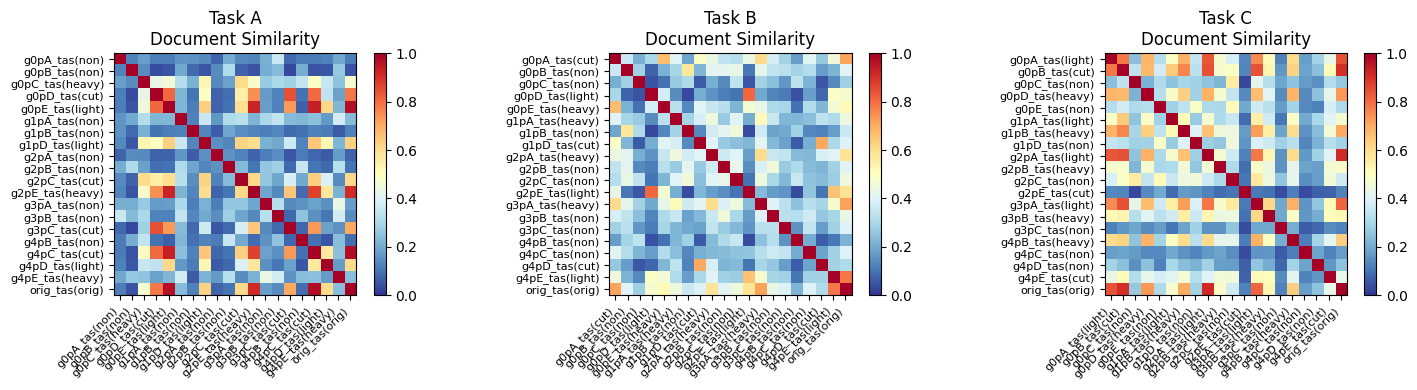

In [32]:

print("Document Similarity Heatmaps")
similarity_heatmap(task_dataframes)


### Summary: Implementation using tfidfclust.py Classes

We have successfully implemented clustering and visualization using the consolidated classes from `tfidfclust.py`:

In [33]:

print(f"Performance Results:")
avg_metrics = task_summary[['accuracy', 'precision', 'recall', 'f1']].mean()
print(f"  Average Accuracy:  {avg_metrics['accuracy']:.1%}")
print(f"  Average Precision: {avg_metrics['precision']:.1%}")
print(f"  Average Recall:    {avg_metrics['recall']:.1%}")
print(f"  Average F1-Score:  {avg_metrics['f1']:.1%}")


Performance Results:
  Average Accuracy:  91.0%
  Average Precision: 91.2%
  Average Recall:    92.8%
  Average F1-Score:  91.9%
